In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import mlxtend as ml

In [2]:
#define parameters to import sql query
server = 'DESKTOP-RDRRI0S'
db = 'AdventureWorks2012'


#create the connection
conn = pyodbc.connect('DRIVER={SQL SERVER};SERVER=' + server + ';DATABASE=' + db + ';Trusted_Connection=yes')



#query db
query = """
SELECT SOH.SalesOrderID,
	   SOD.OrderQty,
	   SOH.OnlineOrderFlag,
	   CASE WHEN
	    SOH.OnlineOrderFlag = 1 THEN 'Online'
		ELSE 'Reseller'
		END AS SalesChannel,
	    PS.Name AS ProductSubCatName
FROM [Sales].[SalesOrderDetail] AS SOD
LEFT JOIN [Sales].[SalesOrderHeader] AS SOH
ON SOD.[SalesOrderID] = SOH.[SalesOrderID]
LEFT JOIN [Production].[Product] AS PP
ON SOD.ProductID = PP.ProductID
LEFT JOIN [Production].[ProductSubcategory] AS PS
ON PP.ProductSubcategoryID = PS.ProductSubcategoryID
LEFT JOIN [Production].[ProductCategory] AS PC
ON PS.ProductCategoryID = PC.ProductCategoryID
WHERE SOH.OnlineOrderFlag = 1

"""

In [3]:
#reading the sql file from the engine
dataset = pd.read_sql(query, conn) 

#converting the sql result into pandas dataframe
df = pd.DataFrame(dataset, columns=['SalesOrderID', 'OrderQty', 'OnlineOrderFlag','SalesChannel', 'ProductSubCatName'])

print(df)

       SalesOrderID  OrderQty  OnlineOrderFlag SalesChannel ProductSubCatName
0             43697         1             True       Online        Road Bikes
1             43698         1             True       Online    Mountain Bikes
2             43699         1             True       Online    Mountain Bikes
3             43700         1             True       Online        Road Bikes
4             43701         1             True       Online    Mountain Bikes
...             ...       ...              ...          ...               ...
60393         75122         1             True       Online           Fenders
60394         75122         1             True       Online              Caps
60395         75123         1             True       Online           Fenders
60396         75123         1             True       Online       Bike Stands
60397         75123         1             True       Online              Caps

[60398 rows x 5 columns]


In [4]:
df.shape

(60398, 5)

In [5]:
df.head()

,SalesOrderID,OrderQty,OnlineOrderFlag,SalesChannel,ProductSubCatName
0,43697,1,True,Online,Road Bikes
1,43698,1,True,Online,Mountain Bikes
2,43699,1,True,Online,Mountain Bikes
3,43700,1,True,Online,Road Bikes
4,43701,1,True,Online,Mountain Bikes


In [6]:
#Drop OnlineOrderFlag and Sales Channel columns
df.drop(columns = ['OnlineOrderFlag', 'SalesChannel'], axis = 1)

,SalesOrderID,OrderQty,ProductSubCatName
0,43697,1,Road Bikes
1,43698,1,Mountain Bikes
2,43699,1,Mountain Bikes
3,43700,1,Road Bikes
4,43701,1,Mountain Bikes
...,...,...,...
60393,75122,1,Fenders
60394,75122,1,Caps
60395,75123,1,Fenders
60396,75123,1,Bike Stands


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Tires and Tubes'),
  Text(1, 0, 'Road Bikes'),
  Text(2, 0, 'Bottles and Cages'),
  Text(3, 0, 'Helmets'),
  Text(4, 0, 'Mountain Bikes'),
  Text(5, 0, 'Jerseys'),
  Text(6, 0, 'Caps'),
  Text(7, 0, 'Touring Bikes'),
  Text(8, 0, 'Fenders'),
  Text(9, 0, 'Gloves')])

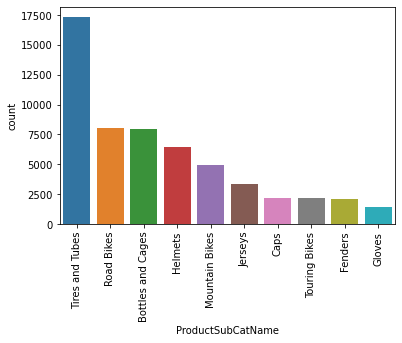

In [7]:
#Checking for the top 10 most popular/demanded items
sns.countplot(x = 'ProductSubCatName', data = df, order = df['ProductSubCatName'].value_counts().iloc[:10].index)
plt.xticks(rotation=90)

In [8]:
#count and consolidate the items into one transaction per row using one hot encoding
df = df.groupby(['SalesOrderID','ProductSubCatName']).size().reset_index(name='count')


basket = (df.groupby(['SalesOrderID', 'ProductSubCatName'])['count']
          .sum().unstack().reset_index().fillna(0)
          .set_index('SalesOrderID'))


#The encoding function
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    

basket_sets = basket.applymap(encode_units)

In [9]:
#Generate frequent item sets with a minimum support of at least 3%
#as this a more favourable support level that could show us more results

frequent_itemsets = apriori(basket_sets, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift")
rules.sort_values('confidence', ascending = False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
9,(Helmets),(Tires and Tubes),0.232836,0.356737,0.100004,0.429503,1.203976,0.016942,1.127548
4,(Fenders),(Mountain Bikes),0.076684,0.179688,0.032467,0.423385,2.356220,0.018688,1.422634
10,(Touring Bikes),(Helmets),0.078347,0.232836,0.032286,0.412090,1.769877,0.014044,1.304902
8,(Tires and Tubes),(Helmets),0.356737,0.232836,0.100004,0.280328,1.203976,0.016942,1.065992
1,(Bottles and Cages),(Helmets),0.172385,0.232836,0.043422,0.251888,1.081826,0.003284,1.025467
3,(Bottles and Cages),(Mountain Bikes),0.172385,0.179688,0.034275,0.198826,1.106502,0.003299,1.023886
2,(Mountain Bikes),(Bottles and Cages),0.179688,0.172385,0.034275,0.190744,1.106502,0.003299,1.022687
7,(Mountain Bikes),(Helmets),0.179688,0.232836,0.033768,0.187928,0.807126,-0.008069,0.944699
0,(Helmets),(Bottles and Cages),0.232836,0.172385,0.043422,0.186491,1.081826,0.003284,1.017339
5,(Mountain Bikes),(Fenders),0.179688,0.076684,0.032467,0.180684,2.356220,0.018688,1.126935


In [10]:
#Replace frozen set
rules['antecedent'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequent'] = rules['consequents'].apply(lambda a: ','.join(list(a)))
rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent,consequent
9,(Helmets),(Tires and Tubes),0.232836,0.356737,0.100004,0.429503,1.203976,0.016942,1.127548,Helmets,Tires and Tubes
4,(Fenders),(Mountain Bikes),0.076684,0.179688,0.032467,0.423385,2.356220,0.018688,1.422634,Fenders,Mountain Bikes
10,(Touring Bikes),(Helmets),0.078347,0.232836,0.032286,0.412090,1.769877,0.014044,1.304902,Touring Bikes,Helmets
8,(Tires and Tubes),(Helmets),0.356737,0.232836,0.100004,0.280328,1.203976,0.016942,1.065992,Tires and Tubes,Helmets
1,(Bottles and Cages),(Helmets),0.172385,0.232836,0.043422,0.251888,1.081826,0.003284,1.025467,Bottles and Cages,Helmets


In [11]:
#Transform the dataframe of rules into a metrix using the lift metric
matrix = rules.pivot(index = 'antecedent', columns = 'consequent', values = 'lift')

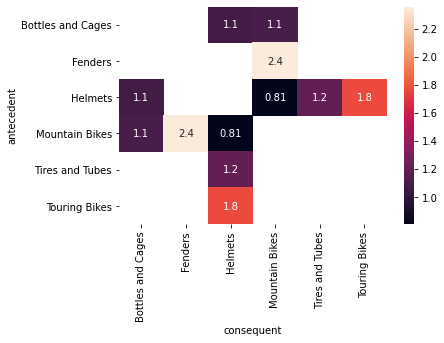

In [12]:
#plot a heatmap of the matrix
sns.heatmap(matrix, annot = True)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)
plt.show()